<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments-Flower/blob/main/Endpoint1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **MODELLO CENTRALIZZATO SU ENDPOINT 1:**



# Data

### imports

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


### dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("anastasiafrosted/my_sequences_endpoint1_hour", download_mode="force_redownload")

train-00000-of-00001.parquet:   0%|          | 0.00/289k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2294 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/109 [00:00<?, ? examples/s]

In [ ]:
training_set = pd.DataFrame(dataset['train'])
test_set = pd.DataFrame(dataset['test'])

In [ ]:
x_train = training_set.copy()
x_test = test_set.copy()

In [ ]:
# Pop two target features into y_train and y_test
y_train = x_train[['avg_execution_time_target', 'avg_scheduling_time_target']]
y_test = x_test[['avg_execution_time_target', 'avg_scheduling_time_target']]

# Save aside timestamps
x_train_timestamps = x_train['timestamp_seq']
x_test_timestamps = x_test['timestamp_seq']

y_train_timestamps = x_train['timestamp_target']
y_test_timestamps = x_test['timestamp_target']

# Drop the targets from predictors
x_train = x_train.drop(['avg_execution_time_target', 'avg_scheduling_time_target', 'timestamp_seq', 'timestamp_target'], axis=1)
x_test = x_test.drop(['avg_execution_time_target', 'avg_scheduling_time_target', 'timestamp_seq', 'timestamp_target'], axis=1)

columns = x_train.columns.tolist()
targets = ['avg_execution_time_target', 'avg_scheduling_time_target']

In [ ]:
# Extract the first value of each list
timestamps = np.array([timestamps[0] for timestamps in x_test_timestamps])
print(len(timestamps))
print(timestamps)

In [ ]:
# Convert each column to a 2D NumPy array (samples x timesteps)
x_train_as_arrays = [np.array(x_train[col].to_list()) for col in columns]
x_test_as_arrays = [np.array(x_test[col].to_list()) for col in columns]

y_train_as_arrays = [np.array(y_train[col].to_list()) for col in targets]
y_test_as_arrays = [np.array(y_test[col].to_list()) for col in targets]

In [ ]:
# Stack columns to create a 3D array (samples, timesteps, features)
x_train = np.stack(x_train_as_arrays, axis=-1)
x_test = np.stack(x_test_as_arrays, axis=-1)

y_train = np.stack(y_train_as_arrays, axis=-1)
y_test = np.stack(y_test_as_arrays, axis=-1)

# Verify the shape of the final 3D array
print(f"x_train shape: {x_train.shape}")  # Expected: (104837, timesteps, 14)
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (2294, 7, 11)
x_test shape: (109, 7, 11)
y_train shape: (2294, 7, 2)
y_test shape: (109, 7, 2)


In [ ]:
print("Input Data Statistics (x_train):")
print(f"Mean: {x_train.mean()}, Std Dev: {x_train.std()}")
print("\nTarget Data Statistics (y_train):")
print(f"Mean: {y_train.mean()}, Std Dev: {y_train.std()}")

Input Data Statistics (x_train):
Mean: 3.990250699789188, Std Dev: 5.470522839533031

Target Data Statistics (y_train):
Mean: 0.06737207563774084, Std Dev: 1.0290278624465312


# Models

In [7]:
# Check GPU availability
if tf.test.gpu_device_name():
    print(f"GPU disponibile: {tf.test.gpu_device_name()}")
else:
    print("GPU non disponibile. L'esecuzione potrebbe essere più lenta.")

GPU non disponibile. L'esecuzione potrebbe essere più lenta.


### Data in the book way

In [9]:
from datasets import load_dataset
df = load_dataset("anastasiafrosted/globus", download_mode="force_redownload")

endpoint1_train.csv:   0%|          | 0.00/481k [00:00<?, ?B/s]

endpoint1_test.csv:   0%|          | 0.00/25.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2307 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/122 [00:00<?, ? examples/s]

In [3]:
train = pd.DataFrame(df['train'])
train['timestamp'] = pd.to_datetime(train['timestamp'], format='%Y-%m-%d:%H')

training_set = train[train['timestamp'] < pd.Timestamp('2023-06-10 20:00')]
val_set = train[train['timestamp'] > pd.Timestamp('2023-06-10 20:00')]

test_set = pd.DataFrame(df['test'])


# drop some columns
timestamps = test_set[['timestamp']].to_numpy()
training_set = training_set.drop(["timestamp", "endpoint_uuid"], axis=1)
val_set = val_set.drop(["timestamp", "endpoint_uuid"], axis=1)
test_set = test_set.drop(["timestamp", "endpoint_uuid"], axis=1)

# get targets
y_train = training_set[['avg_execution_time', 'avg_scheduling_time']]  # Target: 2 features
x_train = training_set.drop(columns=['avg_execution_time', 'avg_scheduling_time'])  # Input: 12 features

y_val = val_set[['avg_execution_time', 'avg_scheduling_time']]  # Target: 2 features
x_val = val_set.drop(columns=['avg_execution_time', 'avg_scheduling_time'])  # Input: 12 features

y_test = test_set[['avg_execution_time', 'avg_scheduling_time']]  # Target: 2 features
x_test = test_set.drop(columns=['avg_execution_time', 'avg_scheduling_time'])  # Input: 12 features

NameError: name 'pd' is not defined

In [ ]:
seq_len = 7

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=x_train,
    targets=np.array([y_train[i:i + seq_len] for i in range(len(y_train) - seq_len + 1)]),
    sequence_length=seq_len,
    batch_size=8,
    shuffle=True)

val_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=x_val,
    targets=np.array([y_val[i:i + seq_len] for i in range(len(y_val) - seq_len + 1)]),
    sequence_length=seq_len,
    batch_size=8,
    shuffle=True)

test_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=x_test,
    targets=np.array([y_test[i:i + seq_len] for i in range(len(y_test) - seq_len + 1)]),
    sequence_length=seq_len,
    batch_size=8,
    shuffle=False
)

print(test_ds)
# Inspect individual batches
for batch in test_ds.take(1):  # Take one batch for demonstration
    inputs, targets = batch
    print(f"Inputs Shape: {inputs.shape}")   # Should be [batch_size, seq_len, 11]
    print(f"Targets Shape: {targets.shape}")  # Should be [batch_size, 2]


 ### Linear

In [ ]:
linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(2, input_shape=[seq_len, x_train.shape[1]]) # Shape is: (8, 7, 11)
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=5000,
    decay_rate=1
)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
linear_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = linear_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping_cb])

In [ ]:
# Evaluate the model on the test set
loss, mae = linear_model.evaluate(test_ds)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Predict on the test set
predictions = linear_model.predict(test_ds)
#print(f"Predictions:\n{predictions[:, 0, :]}")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract actual values from the test dataset
actuals = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Extract the first value of each sequence for predictions and actuals
predicted_first_values = predictions[:, 0, :]  # Shape: [num_sequences, num_targets]
actual_first_values = actuals[:, 0, :]         # Shape: [num_sequences, num_targets]

# Extract the timestamps for the first value of each sequence
sequence_timestamps = timestamps[:len(predicted_first_values)]

# Plot for Target Feature 1
plt.figure(figsize=(21, 6))
plt.plot(sequence_timestamps[:, 0], predicted_first_values[:, 0], label='Predicted Avg Execution Time', linestyle='--', marker='o')
plt.plot(sequence_timestamps[:, 0], actual_first_values[:, 0], label='Actual Avg Execution Time', linestyle='-', marker='x')
plt.title("Predictions vs Actual Values for Avg Execution Time")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=90)  # Rotate xticks
plt.legend()
plt.grid()
plt.show()

# Plot for Target Feature 2
plt.figure(figsize=(21, 6))
plt.plot(sequence_timestamps[:, 0], predicted_first_values[:, 1], label='Predicted Avg Scheduling Time', linestyle='--', marker='o')
plt.plot(sequence_timestamps[:, 0], actual_first_values[:, 1], label='Actual Avg Scheduling Time', linestyle='-', marker='x')
plt.title("Predictions vs Actual Values for Avg Scheduling Time")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=90)  # Rotate xticks
plt.legend()
plt.grid()
plt.show()


NameError: name 'test_ds' is not defined

### RNN

In [ ]:
# Define the model
rnn_model = tf.keras.Sequential([
    # SimpleRNN Layer
    tf.keras.layers.SimpleRNN(7, return_sequences=True, input_shape=(7, 11)),
    # Output Dense Layer
    tf.keras.layers.Dense(2)  # Output layer for 2 targets per timestep
])

In [ ]:
rnn_model.compile(loss=tf.keras.losses.Huber(), metrics=["mae"])
history = rnn_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping_cb])

In [ ]:
# Evaluate the model
test_loss, test_mae = rnn_model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Make predictions
predictions = rnn_model.predict(test_ds)
print(f"Predictions Shape: {predictions.shape}")  # Should be (8, 7, 2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract actual values from the test dataset
actuals = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Extract the first value of each sequence for predictions and actuals
predicted_first_values = predictions[:, 0, :]  # Shape: [num_sequences, num_targets]
actual_first_values = actuals[:, 0, :]         # Shape: [num_sequences, num_targets]

# Extract the timestamps for the first value of each sequence
sequence_timestamps = timestamps[:len(predicted_first_values)]

# Plot for Target Feature 1
plt.figure(figsize=(21, 6))
plt.plot(sequence_timestamps[:,0], predicted_first_values[:, 0], label='Predicted Avg Execution Time', linestyle='--', marker='o')
plt.plot(sequence_timestamps[:,0], actual_first_values[:, 0], label='Actual Avg Execution Time', linestyle='-', marker='x')
plt.title("Predictions vs Actual Values for Avg Execution Time")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=90)  # Rotate xticks
plt.legend()
plt.grid()
plt.show()

# Plot for Target Feature 2
plt.figure(figsize=(21, 6))
plt.plot(sequence_timestamps[:,0], predicted_first_values[:, 1], label='Predicted Avg Cyclomatic Complexity', linestyle='--', marker='o')
plt.plot(sequence_timestamps[:,0], actual_first_values[:, 1], label='Actual Avg Cyclomatic Complexity', linestyle='-', marker='x')
plt.title("Predictions vs Actual Values for Avg Cyclomatic Complexity")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=90)  # Rotate xticks
plt.legend()
plt.grid()
plt.show()


### CNN

In [ ]:
# Define the model
cnn_model = tf.keras.Sequential([
    # SimpleRNN Layer
    tf.keras.layers.Conv1D(filters=2, kernel_size=4, strides=7, activation="relu"),
    tf.keras.layers.GRU(7, return_sequences=True),
    # Output Dense Layer
    tf.keras.layers.Dense(2)  # Output layer for 2 targets per timestep
])

In [ ]:
cnn_model.compile(loss=tf.keras.losses.Huber(), metrics=["mae"])
history = cnn_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping_cb])

In [ ]:
# Evaluate the model
test_loss, test_mae = cnn_model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Make predictions
predictions = cnn_model.predict(test_ds)
print(f"Predictions Shape: {predictions.shape}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract actual values from the test dataset
actuals = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Extract the first value of each sequence for predictions and actuals
predicted_first_values = predictions[:, 0, :]  # Shape: [num_sequences, num_targets]
actual_first_values = actuals[:, 0, :]         # Shape: [num_sequences, num_targets]

# Extract the timestamps for the first value of each sequence
sequence_timestamps = timestamps[:len(predicted_first_values)]

# Plot for Target Feature 1
plt.figure(figsize=(21, 6))
plt.plot(sequence_timestamps[:,0], predicted_first_values[:, 0], label='Predicted Avg Execution Time', linestyle='--', marker='o')
plt.plot(sequence_timestamps[:,0], actual_first_values[:, 0], label='Actual Avg Execution Time', linestyle='-', marker='x')
plt.title("Predictions vs Actual Values for Avg Execution Time")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=90)  # Rotate xticks
plt.legend()
plt.grid()
plt.show()

# Plot for Target Feature 2
plt.figure(figsize=(21, 6))
plt.plot(sequence_timestamps[:,0], predicted_first_values[:, 1], label='Predicted Avg Cyclomatic Complexity', linestyle='--', marker='o')
plt.plot(sequence_timestamps[:,0], actual_first_values[:, 1], label='Actual Avg Cyclomatic Complexity', linestyle='-', marker='x')
plt.title("Predictions vs Actual Values for Avg Cyclomatic Complexity")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=90)  # Rotate xticks
plt.legend()
plt.grid()
plt.show()

### LSTM

In [ ]:
# Class for the LSTM model
class Lstm:
    def __init__(self, learning_rate, sequence_length, num_features, dropout_rate=0.2):
        self.learning_rate = learning_rate
        self.sequence_length = sequence_length  # Number of timesteps in each sequence
        self.num_features = num_features  # Number of features per timestep
        self.dropout_rate = dropout_rate

        # Define the LSTM-based model
        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.sequence_length, self.num_features)),  # Input shape for LSTM
            tf.keras.layers.LSTM(
                15,
                activation='relu',
                return_sequences=True,
                #kernel_regularizer=tf.keras.regularizers.l2(0.01),  # L2 regularization
                #recurrent_dropout=self.dropout_rate  # Recurrent Dropout
            ),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2, activation='linear'))  # Final output layer for each timestep
        ])

        # Define the loss function and optimizer
        self.loss_function = tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def compile(self):
        # Compile the model with optimizer, loss, and additional metrics
        self.model.compile(optimizer=self.optimizer, loss=self.loss_function,
                           metrics=["cosine_similarity", tf.keras.metrics.MeanAbsoluteError()])

    def get_model(self):
        return self.model


In [ ]:
# Usage example
learning_rate = 0.001
sequence_length = 7  # Number of timesteps in each sequence
num_features = 11  # Number of features per timestep

# Instantiate and compile the model
lstm_model = Lstm(learning_rate, sequence_length, num_features)
lstm_model.compile()

# Summary of the model
print(lstm_model.get_model().summary())

In [ ]:
# Train the model
history = lstm_model.get_model().fit(
    x_train, y_train,
    epochs=10,  # Adjust epochs as needed
    batch_size=16,  # Batch size for training
    validation_split=0.2  # Use 20% of the data for validation
)

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - cosine_similarity: 0.0897 - loss: 1.6844 - mean_absolute_error: 0.6798 - val_cosine_similarity: 0.4737 - val_loss: 2.2930 - val_mean_absolute_error: 0.2169
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: 0.5596 - loss: 1.0029 - mean_absolute_error: 0.1716 - val_cosine_similarity: 0.5968 - val_loss: 2.2480 - val_mean_absolute_error: 0.1546
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: 0.6041 - loss: 0.6202 - mean_absolute_error: 0.1064 - val_cosine_similarity: 0.8483 - val_loss: 2.2334 - val_mean_absolute_error: 0.1518
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: 0.7265 - loss: 1.0677 - mean_absolute_error: 0.1162 - val_cosine_similarity: 0.8385 - val_loss: 2.2294 - val_mean_absolute_error: 0.1299
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - cosine_similarity: 0.7798 - loss: 0.8149 - mean_absolute_error: 0.0934 - val_cosine_similarity: 0.7296 - v

#### graph loss

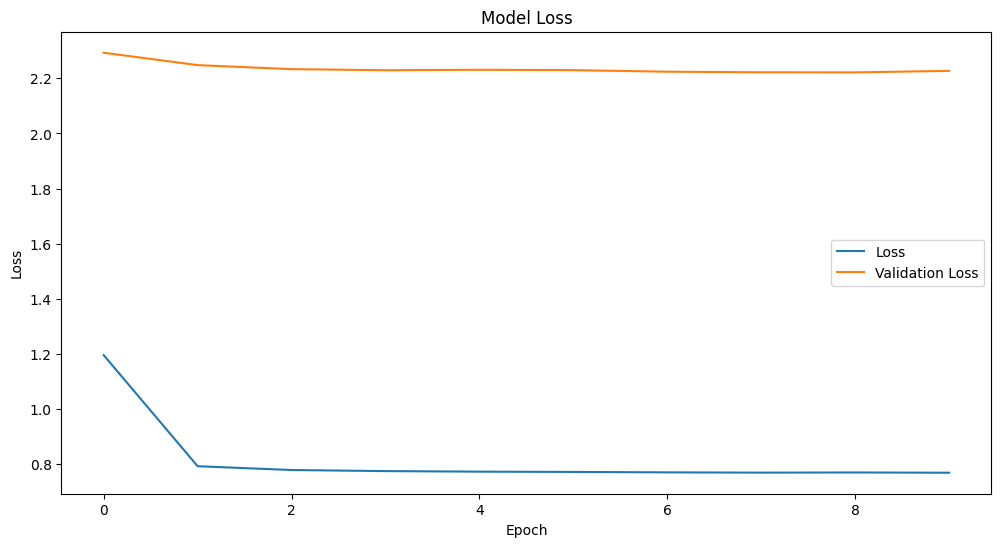

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Evaluation

In [ ]:

# Evaluate the model on test data
test_loss, *test_metrics = lstm_model.get_model().evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
for i, metric in enumerate(test_metrics):
    print(f"Test Metric {i+1}: {metric}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cosine_similarity: 0.9630 - loss: 0.0154 - mean_absolute_error: 0.1052 
Test Loss: 0.015523122623562813
Test Metric 1: 0.9624443650245667
Test Metric 2: 0.10565440356731415


#### Prediction

In [ ]:
# Generate predictions
y_pred = lstm_model.get_model().predict(x_test, verbose=1)

print(f"Predictions shape: {y_pred.shape}")
print(f"First prediction: {y_pred[0]}")


In [ ]:
print(f"Predictions shape: {y_pred.shape}")
print(f"First prediction: {y_pred[1]}")

#### Graph

In [ ]:
# FEATURE 1

# Step 1: Prendi la prima target feature (feature 1)
y_pred_feature1 = y_pred[:, :, 0]  # Shape: (num_samples, timesteps)
y_test_feature1 = y_test[:, :, 0]  # Shape: (num_samples, timesteps)

# Step 2: Prendi il primo valore per ogni sequenza eccetto l'ultima
first_values_pred = np.array([seq[0] for seq in y_pred_feature1])
first_values_actual = np.array([seq[0] for seq in y_test_feature1])

# Step 3: Aggiungi l'intera ultima sequenza
#last_sequence_pred = y_pred_feature1[-1]  # L'ultima sequenza completa
#last_sequence_actual = y_test_feature1[-1]  # L'ultima sequenza completa

# Step 4: Combina i valori in un unico array
#new_array_pred = np.concatenate([first_values_pred, last_sequence_pred])
#new_array_actual = np.concatenate([first_values_actual, last_sequence_actual])

In [ ]:
print(first_values_pred)
print(first_values_actual)

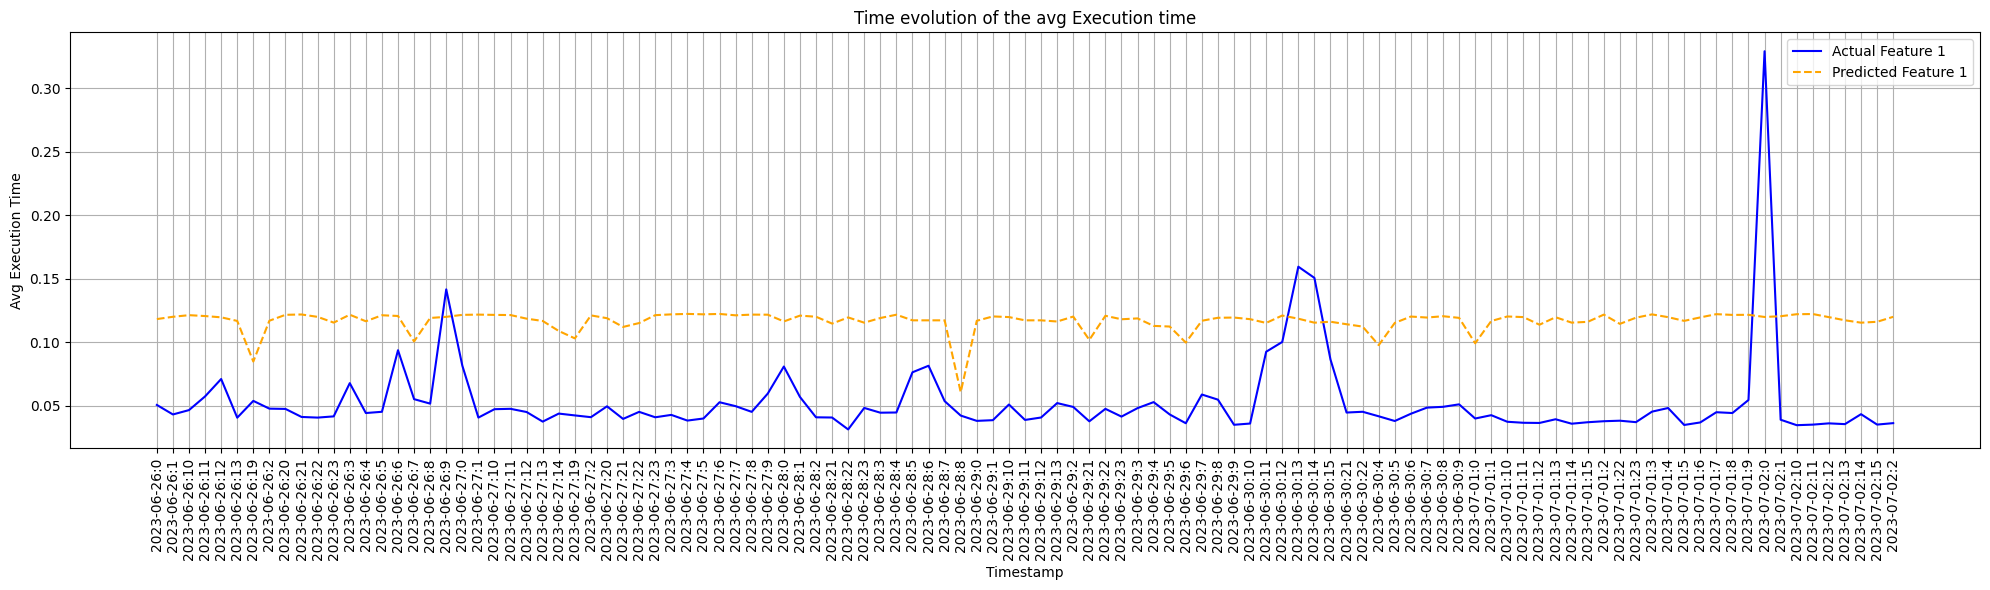

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Grafico
plt.figure(figsize=(20, 6))
plt.plot(timestamps, first_values_actual, label='Actual Feature 1', color='blue')
plt.plot(timestamps, first_values_pred, label='Predicted Feature 1', linestyle='dashed', color='orange')

# Personalizzazione del grafico
plt.title("Time evolution of the avg Execution time")
plt.xlabel("Timestamp")
plt.ylabel("Avg Execution Time")
plt.xticks(rotation=90)  # Rotazione dei timestamp per leggibilità
plt.legend()
plt.grid()
plt.tight_layout()  # Per evitare sovrapposizioni
plt.show()


In [ ]:
# FEATURE 2

# Step 1: Prendi la prima target feature (feature 1)
y_pred_feature2 = y_pred[:, :, 1]  # Shape: (num_samples, timesteps)
y_test_feature2 = y_test[:, :, 1]  # Shape: (num_samples, timesteps)

# Step 2: Prendi il primo valore per ogni sequenza eccetto l'ultima
first_values_pred2 = np.array([seq[0] for seq in y_pred_feature2])
first_values_actual2 = np.array([seq[0] for seq in y_test_feature2])

# Step 3: Aggiungi l'intera ultima sequenza
#last_sequence_pred2 = y_pred_feature2[-1]  # L'ultima sequenza completa
#last_sequence_actual2 = y_test_feature2[-1]  # L'ultima sequenza completa

# Step 4: Combina i valori in un unico array
#new_array_pred2 = np.concatenate([first_values_pred2, last_sequence_pred2])
#new_array_actual2 = np.concatenate([first_values_actual2, last_sequence_actual2])

In [ ]:
print(new_array_pred2)
print(new_array_actual2)

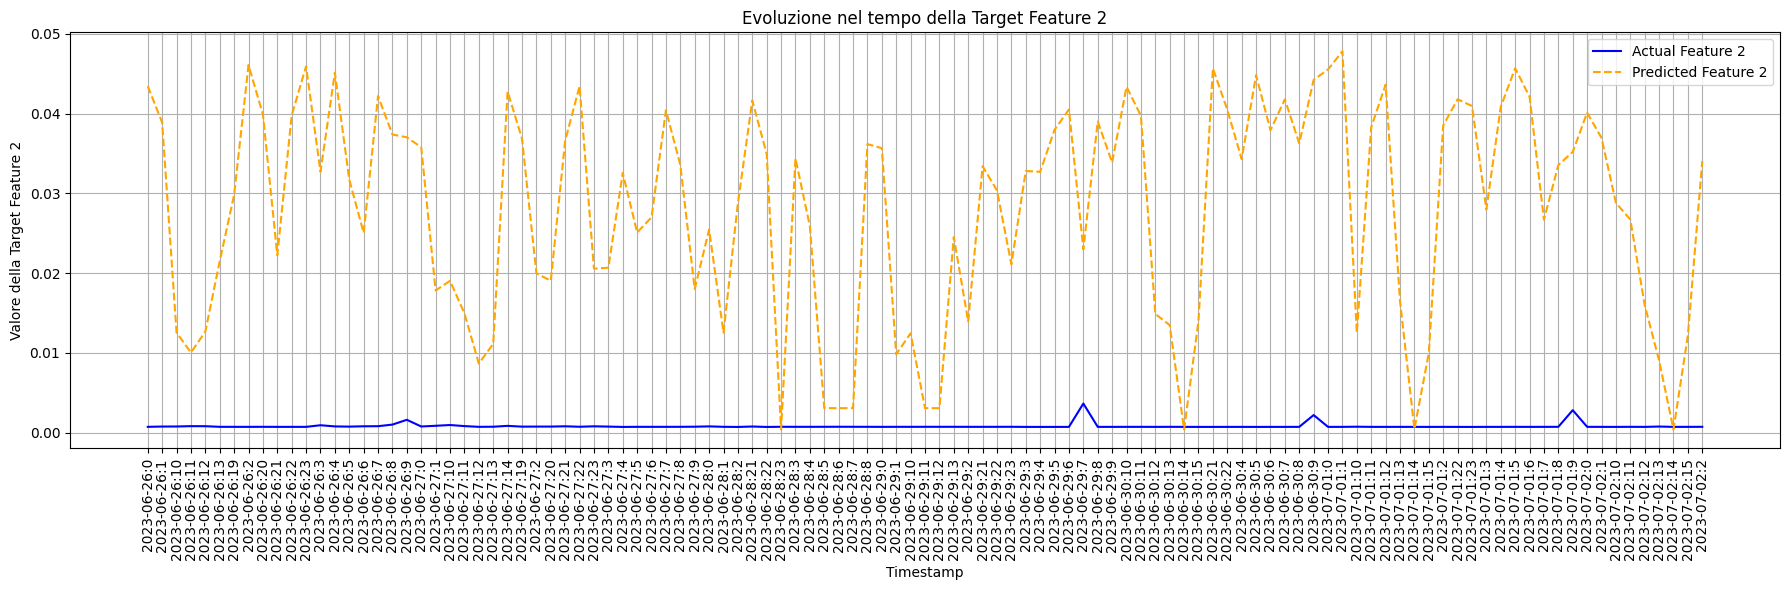

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Grafico
plt.figure(figsize=(18, 6))
plt.plot(timestamps, first_values_actual2, label='Actual Feature 2', color='blue')
plt.plot(timestamps, first_values_pred2, label='Predicted Feature 2', linestyle='dashed', color='orange')

# Personalizzazione del grafico
plt.title("Evoluzione nel tempo della Target Feature 2")
plt.xlabel("Timestamp")
plt.ylabel("Valore della Target Feature 2")
plt.xticks(rotation=90)  # Rotazione dei timestamp per leggibilità
plt.legend()
plt.grid()
plt.tight_layout()  # Per evitare sovrapposizioni
plt.show()

### ARMA MODELS

In [10]:
from datasets import load_dataset
data = load_dataset("anastasiafrosted/globus", download_mode="force_redownload")
train = pd.DataFrame(data['train'])
test = pd.DataFrame(data['test'])

endpoint1_train.csv:   0%|          | 0.00/481k [00:00<?, ?B/s]

endpoint1_test.csv:   0%|          | 0.00/25.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2307 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/122 [00:00<?, ? examples/s]

In [12]:
df = pd.concat([train, test], ignore_index=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d:%H')
df = df.sort_values("timestamp").set_index("timestamp")
df = df.drop("endpoint_uuid", axis=1)
df = df.dropna()
df.tail()

,invocations_per_hour,avg_loc,avg_cyc_complexity,avg_num_of_imports,avg_argument_size,e_type_PBSProProvider,e_type_LSFProvider,e_type_CobaltProvider,e_type_KubernetesProvider,e_type_SlurmProvider,e_type_LocalProvider,avg_execution_time,avg_scheduling_time
timestamp,,,,,,,,,,,,,
2023-07-02 21:00:00,3.502367,13.659204,14.176921,9.905193,4.649658,0.0,0.0,0.0,0.0,0.0,0.0,0.035179,0.000723
2023-07-02 22:00:00,3.113911,13.617087,14.130223,9.943900,4.679201,0.0,0.0,0.0,0.0,0.0,0.0,0.036173,0.000714
2023-07-02 23:00:00,3.558755,13.751329,14.266292,9.796583,4.505451,0.0,0.0,0.0,0.0,0.0,0.0,0.035572,0.000758
2023-07-03 00:00:00,3.784310,13.760884,14.277244,9.788473,4.487707,0.0,0.0,0.0,0.0,0.0,0.0,0.037297,0.000716
2023-07-03 01:00:00,3.702860,14.115248,14.636562,9.399843,4.104643,0.0,0.0,0.0,0.0,0.0,0.0,0.037238,0.000725


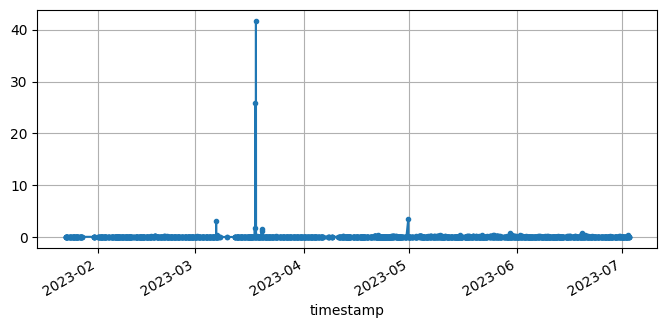

In [13]:
import matplotlib.pyplot as plt

df["2022-12":"2023-07"]['avg_execution_time'].plot(grid=True, marker=".", figsize=(8, 3.5))
#save_fig("daily_ridership_plot")  # extra code – saves the figure for the book
plt.show()

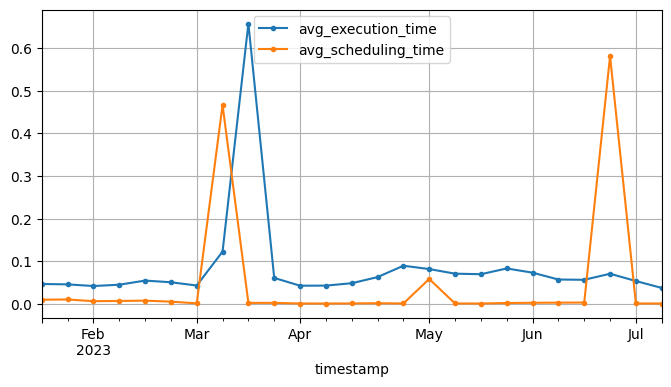

In [14]:
# seasonality, probably none
period = slice("2022", "2024")
df_weekly = df[["avg_execution_time", "avg_scheduling_time"]].resample('W').mean()  # compute the mean for each week
rolling_average_weeks = df_weekly[period].rolling(window=56).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_weekly[period].plot(ax=ax, marker=".")
rolling_average_weeks.plot(ax=ax, grid=True, legend=False)
#save_fig("long_term_ridership_plot")  # extra code – saves the figure for the book
plt.show()

In [19]:
from statsmodels.tsa.arima.model import ARIMA

origin, start_date, end_date = "2023-01-22", "2023-03-30", "2023-07-03"
time_period = pd.date_range(start_date, end_date)
time_series = df.loc[origin:end_date]["avg_scheduling_time"].asfreq("D")
time_series = time_series.dropna()

#print(time_series)
y_preds = []
for today in time_period.shift(-1):
    #print(f"Today: {today}")
    model = ARIMA(time_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
#mae = (y_preds - time_series[time_period]).abs().mean()  # returns 32,040.7
print(y_preds)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

2023-03-30    43    0.001707
dtype: float64
2023-03-31     44    0.00157
dtype: float64
2023-04-01    45    0.001509
dtype: float64
2023-04-02    45    0.001509
dtype: float64
2023-04-03    45    0.001509
dtype: float64
                          ...              
2023-06-29    76    0.001261
dtype: float64
2023-06-30    76    0.001261
dtype: float64
2023-07-01    76    0.001261
dtype: float64
2023-07-02    76    0.001261
dtype: float64
2023-07-03    76    0.001261
dtype: float64
Freq: D, Length: 96, dtype: object


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


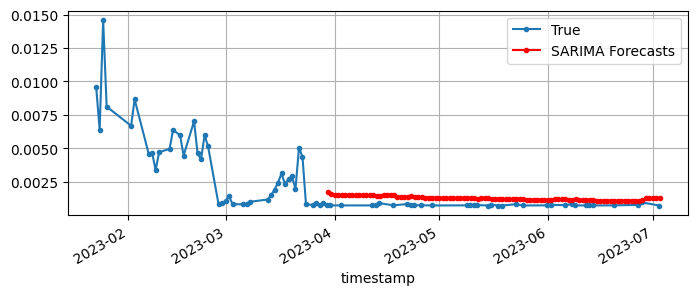

In [20]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
time_series.plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()